In [1]:
pip install pandas

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install SciPy

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow
import os
import statistics as stats
from collections import defaultdict
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50 as resnet50
from tensorflow.keras.applications.inception_v3 import InceptionV3 as inception
from tensorflow.keras.applications.vgg16 import VGG16 as vgg16
from tensorflow.keras.applications.densenet import DenseNet169 as densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D,Flatten,InputLayer, BatchNormalization, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model   


In [5]:
##create a generator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,                          
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [6]:
##datasets splicings
train_dataset  = train_datagen.flow_from_directory(directory = 'breast_data/Data/train',
                                                   target_size = (32,32),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

valid_dataset = valid_datagen.flow_from_directory(directory = 'breast_data/Data/valid',
                                                  target_size = (32,32),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

test_dataset = test_datagen.flow_from_directory(directory = 'breast_data/Data/test',
                                                  target_size = (32,32),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [7]:
model_name = resnet50
input_t =(32,32,3)
model = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)

model2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)

model3 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
model_tune1 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
model_tune2 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
model_tune3 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)
model_tune4 = model_name(include_top=False,
                   weights="imagenet",
                   input_shape=input_t)

In [8]:
# get the layer index
def getLayerIndex(model_i, layer_name):
    for pos, layer_g in enumerate(model_i.layers):
        if layer_g.name == layer_name:
            return pos


In [9]:
# get the convolved layers into an array for looping
convolved_layers = []

for layer in model.layers:

    t = np.array(layer.get_weights()).ndim
    array = np.array(layer.get_weights())
    if (model_name != resnet50) or (model_name != vgg16):
        if (len(array) > 0) and (t > 2):
            index = getLayerIndex(model, layer.name)
            # append the convolved layer
            convolved_layers.append(index)
            # print(str(len(array)) + "for:" + layer.name + "at index:" + str(index))
    if (model_name == resnet50) or (model_name == vgg16):
        if len(array) > 0 and (t != 2):
            index = getLayerIndex(model, layer.name)
            # append the convolved layer
            convolved_layers.append(index)
            # print(str(len(array)) + "for:" + layer.name + "at index:" + str(index))

# get the total number of weights in the array
total_layer_weights = 0
sum_positives = 0
sum_negatives = 0

# create a dictionary with layer index and positive values identified
layer_positives_dict = defaultdict(list)

# create a dictionary for storing the layers and their +ve values probabilities
layer_probs_dict = defaultdict(list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [10]:
# list the convolved layers
for c_layer in range(len(convolved_layers)):
    # create array for array matrices,feature values and convolved values for each layer
    layer_array_matrices = []
    layer_feature_sums = []
    layer_convolved_values_sum = []

    # get the arrays matrices(batches) pixel
    for i in range(len(model.layers[convolved_layers[c_layer]].get_weights()[0])):
        # get the values for each feature
        ######print("channels(image):"+str(len(model.layers[convolved_layers[c_layer]].get_weights()[0][i])))
        for x in range(len(model.layers[convolved_layers[c_layer]].get_weights()[0][i])):
            # return all the values in the convolutional feature
            total_array = np.array(model.layers[convolved_layers[c_layer]].get_weights()[0][i][x])
            # return all the negative values in the convolutional feature
            x2 = np.array(model.layers[convolved_layers[c_layer]].get_weights()[0][i][x]) < 0
            for c in range(len(x2)):
                ###print("all the trues in depth: " + str(c + 1) + " are for feature: " + str(x + 1))
                sum_negatives += sum(x2[c])
                # print(sum(x2[c]))
            # return all the values
            for y in range(len(total_array)):
                total_layer_weights += len(total_array[y])

            x1 = np.array(model.layers[convolved_layers[c_layer]].get_weights()[0][i][x]) > 0
            # get the values for each channel
            for a in range(len(x1)):
                value_pix = sum(x1[a])
                # get the positive values
                sum_positives += value_pix

                ######print(value_pix)
    list_sums = []
    list_sums.append((str(convolved_layers[c_layer]), sum_positives))
    layer_positives_dict.update(list_sums)

    # print the probabilities for each layer
    layer_pos_prob = sum_positives / total_layer_weights

    # create +ves values array
    positives_array = []
    for key, val in layer_positives_dict.items():
        # print(key, "corresponds to:",val," positive values")
        positives_array.append(val)
       
    list_layer_probs = []
    list_layer_probs.append((str(convolved_layers[c_layer]), layer_pos_prob))
    layer_probs_dict.update(list_layer_probs)

In [11]:
median_layer = stats.median(convolved_layers)

# create dictionary for storing selected median layers
second_layer_probs_dict = defaultdict(list)
# store the new list of layers to be matched with the mean probability
second_half_layers = []

# store all probabilities for the selected upper half layers
second_half_probs = []
# loop through the layers and print those layers above the median
for lyr, val in layer_probs_dict.items():
    # print(lyr, "Layer prob:", val)
    if int(lyr) > median_layer:
        # store the probabilities of the upper half selected convolved layers
        #print(lyr, "Layer prob:", val)
        # update the sum of selected layers probabilities
        second_half_probs.append(val)
        second_half_layers.append((lyr, val))
        second_layer_probs_dict.update(second_half_layers)

# get the mean of the layers
selected_layers_mean = stats.mean(second_half_probs)
final_selected_layers = []
# now get the final layers list whose value exceed the mean
for s_lyr, v in second_layer_probs_dict.items():
    # get the probabilities that are lower than the mean probability
    if v < selected_layers_mean:
        # store the probabilities of the upper half selected convolved layers
        final_selected_layers.append(s_lyr)

In [12]:

# for positive cosines similarities
pcs_h_layers =[29,32,54,146,158]
pcs_l_layers =[13,14,35,57,67,77] #lower cosine
for sb_layer in model.layers:
    # sb_layer.trainable = False
    index = getLayerIndex(model, sb_layer.name)
    #for b in final_selected_layers:
    for b in pcs_h_layers:
        if b == index:
            sb_layer.trainable = True
            #print(str(sb_layer.name) + " and index is" + str(b))
            print(sb_layer.name,sb_layer.trainable)

#for negative cosine similarities
# for model 2
# for positive cosines similarities
ncs_h_layers =[146,155,158,165,168,171]
ncs_l_layers =[2,7,13,14,35,45,46,67]
for sbs_layer in model2.layers:
    # sb_layer.trainable = False
    index = getLayerIndex(model2, sbs_layer.name)
    #for b in final_selected_layers:
    for b in ncs_h_layers:
        if b == index:
            sb_layer.trainable = True
            #print(str(sb_layer.name) + " and index is" + str(b))
            print(sb_layer.name,sb_layer.trainable)

#for positive negative cosine similarities
# for model 3
pncs_h_layers =[32,57,77,109,126,139] #high cosine,,
pncs_l_layers =[2,7,13,22,64,71,81] #lower cosine
for sbs_layer in model3.layers:
    # sb_layer.trainable = False
    index = getLayerIndex(model3, sbs_layer.name)
    #for b in final_selected_layers:
    for b in pncs_h_layers:
        if b == index:
            sb_layer.trainable = True
            #print(str(sb_layer.name) + " and index is" + str(b))
            print(sb_layer.name,sb_layer.trainable)


#finetune by removeing the last layer
for lst_layer in model_tune1.layers[:-2]:
    lst_layer.trainable = False
    
####end of the last layer
#finetune by removeing the 2nd last layer
for scnd_st_layer in model_tune2.layers[:-3]:
    scnd_st_layer.trainable = False
    
####end of the last layer
#finetune by removeing the 3rd last layer
for thrd_layer in model_tune3.layers[:-4]:
    thrd_layer.trainable = False
    

    
####end of the last layer
#for feature extraction
for ftr_layer in model_tune4.layers:
    ftr_layer.trainable = False

# try the transfer learning model
to_res = (224, 224)


conv2_block3_1_conv True
conv2_block3_2_conv True
conv3_block2_2_conv True
conv5_block1_2_conv True
conv5_block2_2_conv True
conv5_block3_out True
conv5_block3_out True
conv5_block3_out True
conv5_block3_out True
conv5_block3_out True
conv5_block3_out True
conv5_block3_out True
conv5_block3_out True
conv5_block3_out True
conv5_block3_out True
conv5_block3_out True
conv5_block3_out True


In [13]:

t_model = Sequential()
t_model.add(model)
t_model.add(Flatten())
#t_model.add(layers.BatchNormalization())
t_model.add(layers.Dense(64, activation='relu'))
t_model.add(layers.Dropout(0.5))
#t_model.add(layers.BatchNormalization())
t_model.add(layers.Dense(4, activation='softmax'))


#for model 2
t_model2 = Sequential()
t_model2.add(model2)
t_model2.add(Flatten())
#t_model2.add(layers.BatchNormalization())
t_model2.add(layers.Dense(64, activation='relu'))
t_model2.add(layers.Dropout(0.5))
#t_model2.add(layers.BatchNormalization())
t_model2.add(layers.Dense(4, activation='softmax'))


#for model 2
t_model3 = Sequential()
t_model3.add(model3)
t_model3.add(Flatten())
#t_model3.add(layers.BatchNormalization())
t_model3.add(layers.Dense(64, activation='relu'))
t_model3.add(layers.Dropout(0.5))
#t_model3.add(layers.BatchNormalization())
t_model3.add(layers.Dense(4, activation='softmax'))


#for model 2
t_model4 = Sequential()
t_model4.add(model_tune1)
t_model4.add(Flatten())
#t_model4.add(layers.BatchNormalization())
t_model4.add(layers.Dense(64, activation='relu'))
t_model4.add(layers.Dropout(0.5))
#t_model4.add(layers.BatchNormalization())
t_model4.add(layers.Dense(4, activation='softmax'))

#for model 2
t_model5 = Sequential()
t_model5.add(model_tune2)
t_model5.add(Flatten())
#t_model5.add(layers.BatchNormalization())
t_model5.add(layers.Dense(64, activation='relu'))
t_model5.add(layers.Dropout(0.5))
#t_model5.add(layers.BatchNormalization())
t_model5.add(layers.Dense(4, activation='softmax'))

#for model 2
t_model6 = Sequential()
t_model6.add(model_tune3)
t_model6.add(Flatten())
#t_model6.add(layers.BatchNormalization())
t_model6.add(layers.Dense(64, activation='relu'))
t_model6.add(layers.Dropout(0.5))
#t_model6.add(layers.BatchNormalization())
t_model6.add(layers.Dense(4, activation='softmax'))


#for model 2
t_model7 = Sequential()
t_model7.add(model_tune3)
t_model7.add(Flatten())
#t_model7.add(layers.BatchNormalization())
t_model7.add(layers.Dense(64, activation='relu'))
t_model7.add(layers.Dropout(0.5))
#t_model7.add(layers.BatchNormalization())
t_model7.add(layers.Dense(4, activation='softmax'))

In [14]:
class myCallback(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

In [15]:
#positive cosine similarity
t_model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
history = t_model.fit(train_dataset,validation_data=valid_dataset,shuffle=True, epochs=100, verbose=1)


Epoch 1/100
10/10 [==============================] - 16s 775ms/step - loss: 2.5334 - accuracy: 0.2795 - val_loss: 1.6297 - val_accuracy: 0.1944
Epoch 2/100
10/10 [==============================] - 4s 347ms/step - loss: 1.9971 - accuracy: 0.3088 - val_loss: 6.2855 - val_accuracy: 0.1806
Epoch 3/100
10/10 [==============================] - 4s 370ms/step - loss: 1.6292 - accuracy: 0.3528 - val_loss: 4.2335 - val_accuracy: 0.2083
Epoch 4/100
10/10 [==============================] - 3s 341ms/step - loss: 1.3988 - accuracy: 0.3740 - val_loss: 3.9261 - val_accuracy: 0.1806
Epoch 5/100
10/10 [==============================] - 3s 341ms/step - loss: 1.5003 - accuracy: 0.4005 - val_loss: 9.6381 - val_accuracy: 0.1806
Epoch 6/100
10/10 [==============================] - 3s 339ms/step - loss: 1.4098 - accuracy: 0.4157 - val_loss: 21.6777 - val_accuracy: 0.1806
Epoch 7/100
10/10 [==============================] - 3s 332ms/step - loss: 1.2742 - accuracy: 0.4676 - val_loss: 6.9419 - val_accuracy: 0.20

Epoch 58/100
10/10 [==============================] - 4s 357ms/step - loss: 0.5364 - accuracy: 0.7620 - val_loss: 5.8430 - val_accuracy: 0.1111
Epoch 59/100
10/10 [==============================] - 4s 371ms/step - loss: 0.5734 - accuracy: 0.7674 - val_loss: 2.9473 - val_accuracy: 0.1389
Epoch 60/100
10/10 [==============================] - 4s 365ms/step - loss: 0.6110 - accuracy: 0.7447 - val_loss: 2.5899 - val_accuracy: 0.2083
Epoch 61/100
10/10 [==============================] - 3s 338ms/step - loss: 0.5906 - accuracy: 0.7753 - val_loss: 3.0648 - val_accuracy: 0.1944
Epoch 62/100
10/10 [==============================] - 4s 347ms/step - loss: 0.5011 - accuracy: 0.7999 - val_loss: 3.3458 - val_accuracy: 0.1944
Epoch 63/100
10/10 [==============================] - 3s 339ms/step - loss: 0.5036 - accuracy: 0.8262 - val_loss: 3.4419 - val_accuracy: 0.2083
Epoch 64/100
10/10 [==============================] - 4s 390ms/step - loss: 0.5101 - accuracy: 0.7858 - val_loss: 3.8762 - val_accuracy:

In [16]:
#negative cosine similarity look
#for model2
t_model2.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
history2 = t_model2.fit(train_dataset,validation_data=valid_dataset, shuffle=True, epochs=100, verbose=1)


Epoch 1/100
10/10 [==============================] - 11s 492ms/step - loss: 2.4397 - accuracy: 0.2679 - val_loss: 2.0128 - val_accuracy: 0.3056
Epoch 2/100
10/10 [==============================] - 3s 336ms/step - loss: 1.9870 - accuracy: 0.3079 - val_loss: 3.9256 - val_accuracy: 0.3194
Epoch 3/100
10/10 [==============================] - 3s 352ms/step - loss: 1.6966 - accuracy: 0.3729 - val_loss: 3.5497 - val_accuracy: 0.3194
Epoch 4/100
10/10 [==============================] - 3s 345ms/step - loss: 1.4934 - accuracy: 0.3718 - val_loss: 5.0831 - val_accuracy: 0.2083
Epoch 5/100
10/10 [==============================] - 3s 343ms/step - loss: 1.4100 - accuracy: 0.4387 - val_loss: 4.7444 - val_accuracy: 0.2083
Epoch 6/100
10/10 [==============================] - 3s 353ms/step - loss: 1.4004 - accuracy: 0.4033 - val_loss: 2.2307 - val_accuracy: 0.2083
Epoch 7/100
10/10 [==============================] - 3s 335ms/step - loss: 1.2542 - accuracy: 0.4463 - val_loss: 1.8165 - val_accuracy: 0.208

Epoch 58/100
10/10 [==============================] - 3s 341ms/step - loss: 0.6222 - accuracy: 0.7240 - val_loss: 2.2255 - val_accuracy: 0.1944
Epoch 59/100
10/10 [==============================] - 3s 347ms/step - loss: 0.6108 - accuracy: 0.7428 - val_loss: 2.3801 - val_accuracy: 0.2778
Epoch 60/100
10/10 [==============================] - 4s 363ms/step - loss: 0.6155 - accuracy: 0.7246 - val_loss: 2.1983 - val_accuracy: 0.3611
Epoch 61/100
10/10 [==============================] - 3s 328ms/step - loss: 0.6016 - accuracy: 0.7216 - val_loss: 2.1830 - val_accuracy: 0.2222
Epoch 62/100
10/10 [==============================] - 3s 339ms/step - loss: 0.6011 - accuracy: 0.7219 - val_loss: 2.0587 - val_accuracy: 0.3194
Epoch 63/100
10/10 [==============================] - 3s 359ms/step - loss: 0.5802 - accuracy: 0.7153 - val_loss: 2.2746 - val_accuracy: 0.3333
Epoch 64/100
10/10 [==============================] - 3s 355ms/step - loss: 0.5639 - accuracy: 0.7490 - val_loss: 2.6051 - val_accuracy:

In [17]:
#for model3
t_model3.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
history3 = t_model3.fit(train_dataset,validation_data=valid_dataset, shuffle=True, epochs=100, verbose=1)


Epoch 1/100
10/10 [==============================] - 10s 470ms/step - loss: 2.9821 - accuracy: 0.2355 - val_loss: 2.1056 - val_accuracy: 0.3194
Epoch 2/100
10/10 [==============================] - 4s 360ms/step - loss: 2.1851 - accuracy: 0.3073 - val_loss: 2.3625 - val_accuracy: 0.3194
Epoch 3/100
10/10 [==============================] - 3s 340ms/step - loss: 1.7900 - accuracy: 0.3507 - val_loss: 2.2660 - val_accuracy: 0.3194
Epoch 4/100
10/10 [==============================] - 3s 346ms/step - loss: 1.7918 - accuracy: 0.3872 - val_loss: 2.8543 - val_accuracy: 0.2083
Epoch 5/100
10/10 [==============================] - 3s 319ms/step - loss: 1.3709 - accuracy: 0.4425 - val_loss: 2.5729 - val_accuracy: 0.3194
Epoch 6/100
10/10 [==============================] - 3s 328ms/step - loss: 1.3163 - accuracy: 0.4362 - val_loss: 3.5505 - val_accuracy: 0.2083
Epoch 7/100
10/10 [==============================] - 3s 340ms/step - loss: 1.3351 - accuracy: 0.4463 - val_loss: 5.0013 - val_accuracy: 0.166

Epoch 58/100
10/10 [==============================] - 3s 339ms/step - loss: 0.6075 - accuracy: 0.7258 - val_loss: 2.5633 - val_accuracy: 0.1944
Epoch 59/100
10/10 [==============================] - 3s 339ms/step - loss: 0.6684 - accuracy: 0.7175 - val_loss: 2.7951 - val_accuracy: 0.1944
Epoch 60/100
10/10 [==============================] - 4s 354ms/step - loss: 0.6341 - accuracy: 0.7565 - val_loss: 3.0375 - val_accuracy: 0.2083
Epoch 61/100
10/10 [==============================] - 3s 355ms/step - loss: 0.5838 - accuracy: 0.7420 - val_loss: 3.3174 - val_accuracy: 0.2083
Epoch 62/100
10/10 [==============================] - 3s 352ms/step - loss: 0.6114 - accuracy: 0.7439 - val_loss: 3.4890 - val_accuracy: 0.2083
Epoch 63/100
10/10 [==============================] - 4s 358ms/step - loss: 0.7408 - accuracy: 0.6968 - val_loss: 3.5086 - val_accuracy: 0.2083
Epoch 64/100
10/10 [==============================] - 3s 331ms/step - loss: 0.5648 - accuracy: 0.7756 - val_loss: 3.4415 - val_accuracy:

In [18]:
#for model3
t_model4.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
history4= t_model4.fit(train_dataset,validation_data=valid_dataset, shuffle=True, epochs=100, verbose=1)



Epoch 1/100
10/10 [==============================] - 8s 499ms/step - loss: 2.5579 - accuracy: 0.2287 - val_loss: 1.5910 - val_accuracy: 0.3194
Epoch 2/100
10/10 [==============================] - 3s 351ms/step - loss: 1.9812 - accuracy: 0.2239 - val_loss: 1.4864 - val_accuracy: 0.3194
Epoch 3/100
10/10 [==============================] - 3s 340ms/step - loss: 1.8096 - accuracy: 0.2218 - val_loss: 1.4407 - val_accuracy: 0.3194
Epoch 4/100
10/10 [==============================] - 4s 354ms/step - loss: 1.7016 - accuracy: 0.2567 - val_loss: 1.4186 - val_accuracy: 0.3194
Epoch 5/100
10/10 [==============================] - 3s 329ms/step - loss: 1.5453 - accuracy: 0.2566 - val_loss: 1.3908 - val_accuracy: 0.3194
Epoch 6/100
10/10 [==============================] - 3s 336ms/step - loss: 1.4734 - accuracy: 0.2485 - val_loss: 1.3703 - val_accuracy: 0.3194
Epoch 7/100
10/10 [==============================] - 3s 340ms/step - loss: 1.4157 - accuracy: 0.2582 - val_loss: 1.3609 - val_accuracy: 0.3194

Epoch 58/100
10/10 [==============================] - 3s 331ms/step - loss: 1.0715 - accuracy: 0.5555 - val_loss: 1.1708 - val_accuracy: 0.4167
Epoch 59/100
10/10 [==============================] - 3s 338ms/step - loss: 1.1163 - accuracy: 0.4760 - val_loss: 1.1613 - val_accuracy: 0.4167
Epoch 60/100
10/10 [==============================] - 3s 335ms/step - loss: 1.0756 - accuracy: 0.5102 - val_loss: 1.1537 - val_accuracy: 0.4444
Epoch 61/100
10/10 [==============================] - 3s 341ms/step - loss: 1.0547 - accuracy: 0.5422 - val_loss: 1.1629 - val_accuracy: 0.4306
Epoch 62/100
10/10 [==============================] - 3s 346ms/step - loss: 1.0505 - accuracy: 0.5271 - val_loss: 1.1579 - val_accuracy: 0.4306
Epoch 63/100
10/10 [==============================] - 4s 361ms/step - loss: 1.0586 - accuracy: 0.5287 - val_loss: 1.1604 - val_accuracy: 0.4306
Epoch 64/100
10/10 [==============================] - 3s 340ms/step - loss: 1.0959 - accuracy: 0.4938 - val_loss: 1.1543 - val_accuracy:

In [19]:
#for model3
t_model5.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
history5 = t_model5.fit(train_dataset,validation_data=valid_dataset, shuffle=True, epochs=100, verbose=1)


Epoch 1/100
10/10 [==============================] - 8s 491ms/step - loss: 2.5614 - accuracy: 0.2836 - val_loss: 2.0139 - val_accuracy: 0.2083
Epoch 2/100
10/10 [==============================] - 3s 335ms/step - loss: 1.7957 - accuracy: 0.3663 - val_loss: 1.6869 - val_accuracy: 0.3472
Epoch 3/100
10/10 [==============================] - 3s 336ms/step - loss: 1.5066 - accuracy: 0.3911 - val_loss: 1.4859 - val_accuracy: 0.3333
Epoch 4/100
10/10 [==============================] - 3s 342ms/step - loss: 1.3334 - accuracy: 0.4050 - val_loss: 1.4217 - val_accuracy: 0.3194
Epoch 5/100
10/10 [==============================] - 3s 345ms/step - loss: 1.2303 - accuracy: 0.4611 - val_loss: 1.4080 - val_accuracy: 0.3194
Epoch 6/100
10/10 [==============================] - 3s 329ms/step - loss: 1.1712 - accuracy: 0.4725 - val_loss: 1.4093 - val_accuracy: 0.3194
Epoch 7/100
10/10 [==============================] - 3s 336ms/step - loss: 1.1892 - accuracy: 0.4701 - val_loss: 1.4169 - val_accuracy: 0.3194

Epoch 58/100
10/10 [==============================] - 3s 344ms/step - loss: 0.9735 - accuracy: 0.5563 - val_loss: 1.1280 - val_accuracy: 0.4444
Epoch 59/100
10/10 [==============================] - 4s 378ms/step - loss: 0.9876 - accuracy: 0.5485 - val_loss: 1.1284 - val_accuracy: 0.4444
Epoch 60/100
10/10 [==============================] - 3s 347ms/step - loss: 0.9375 - accuracy: 0.5635 - val_loss: 1.1321 - val_accuracy: 0.4306
Epoch 61/100
10/10 [==============================] - 3s 341ms/step - loss: 0.9212 - accuracy: 0.5752 - val_loss: 1.1336 - val_accuracy: 0.4167
Epoch 62/100
10/10 [==============================] - 3s 343ms/step - loss: 0.9499 - accuracy: 0.5620 - val_loss: 1.1251 - val_accuracy: 0.4167
Epoch 63/100
10/10 [==============================] - 3s 337ms/step - loss: 1.0159 - accuracy: 0.5262 - val_loss: 1.1384 - val_accuracy: 0.4444
Epoch 64/100
10/10 [==============================] - 3s 336ms/step - loss: 0.9733 - accuracy: 0.5682 - val_loss: 1.1330 - val_accuracy:

In [20]:
#for model3
t_model6.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
history6 = t_model6.fit(train_dataset,validation_data=valid_dataset, shuffle=True, epochs=100, verbose=1)


Epoch 1/100
10/10 [==============================] - 8s 496ms/step - loss: 2.6703 - accuracy: 0.2860 - val_loss: 1.5937 - val_accuracy: 0.2917
Epoch 2/100
10/10 [==============================] - 3s 334ms/step - loss: 1.7012 - accuracy: 0.3783 - val_loss: 1.4628 - val_accuracy: 0.3194
Epoch 3/100
10/10 [==============================] - 3s 362ms/step - loss: 1.5103 - accuracy: 0.4307 - val_loss: 1.4958 - val_accuracy: 0.3194
Epoch 4/100
10/10 [==============================] - 3s 327ms/step - loss: 1.2940 - accuracy: 0.4925 - val_loss: 1.4652 - val_accuracy: 0.3194
Epoch 5/100
10/10 [==============================] - 3s 345ms/step - loss: 1.3083 - accuracy: 0.4705 - val_loss: 1.4588 - val_accuracy: 0.3194
Epoch 6/100
10/10 [==============================] - 3s 342ms/step - loss: 1.1569 - accuracy: 0.5041 - val_loss: 1.4577 - val_accuracy: 0.3194
Epoch 7/100
10/10 [==============================] - 3s 340ms/step - loss: 1.0887 - accuracy: 0.5146 - val_loss: 1.4398 - val_accuracy: 0.3194

Epoch 58/100
10/10 [==============================] - 3s 329ms/step - loss: 0.9109 - accuracy: 0.5748 - val_loss: 1.1371 - val_accuracy: 0.4861
Epoch 59/100
10/10 [==============================] - 3s 335ms/step - loss: 0.9455 - accuracy: 0.6117 - val_loss: 1.1787 - val_accuracy: 0.4583
Epoch 60/100
10/10 [==============================] - 3s 352ms/step - loss: 0.9184 - accuracy: 0.5806 - val_loss: 1.2098 - val_accuracy: 0.4583
Epoch 61/100
10/10 [==============================] - 3s 352ms/step - loss: 0.9039 - accuracy: 0.5746 - val_loss: 1.1695 - val_accuracy: 0.4444
Epoch 62/100
10/10 [==============================] - 3s 348ms/step - loss: 0.8920 - accuracy: 0.5908 - val_loss: 1.1332 - val_accuracy: 0.4583
Epoch 63/100
10/10 [==============================] - 3s 361ms/step - loss: 0.8824 - accuracy: 0.6046 - val_loss: 1.1226 - val_accuracy: 0.4722
Epoch 64/100
10/10 [==============================] - 4s 372ms/step - loss: 0.8969 - accuracy: 0.5921 - val_loss: 1.1256 - val_accuracy:

In [21]:
#for model3
t_model7.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer=optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])
history7 = t_model7.fit(train_dataset,validation_data=valid_dataset, shuffle=True, epochs=100,verbose=1)


Epoch 1/100
10/10 [==============================] - 8s 527ms/step - loss: 1.9165 - accuracy: 0.3213 - val_loss: 1.5816 - val_accuracy: 0.3889
Epoch 2/100
10/10 [==============================] - 3s 342ms/step - loss: 1.4827 - accuracy: 0.4496 - val_loss: 1.8736 - val_accuracy: 0.4167
Epoch 3/100
10/10 [==============================] - 3s 342ms/step - loss: 1.2600 - accuracy: 0.4723 - val_loss: 1.7743 - val_accuracy: 0.3056
Epoch 4/100
10/10 [==============================] - 3s 334ms/step - loss: 1.2100 - accuracy: 0.4771 - val_loss: 1.6740 - val_accuracy: 0.3472
Epoch 5/100
10/10 [==============================] - 3s 345ms/step - loss: 1.1477 - accuracy: 0.5164 - val_loss: 1.5088 - val_accuracy: 0.3611
Epoch 6/100
10/10 [==============================] - 4s 359ms/step - loss: 1.0416 - accuracy: 0.5307 - val_loss: 1.4207 - val_accuracy: 0.3194
Epoch 7/100
10/10 [==============================] - 3s 346ms/step - loss: 0.9985 - accuracy: 0.5584 - val_loss: 1.2707 - val_accuracy: 0.3750

Epoch 58/100
10/10 [==============================] - 3s 346ms/step - loss: 0.8584 - accuracy: 0.5937 - val_loss: 1.3900 - val_accuracy: 0.4167
Epoch 59/100
10/10 [==============================] - 3s 335ms/step - loss: 0.9320 - accuracy: 0.5801 - val_loss: 1.2257 - val_accuracy: 0.4306
Epoch 60/100
10/10 [==============================] - 3s 339ms/step - loss: 0.8856 - accuracy: 0.5977 - val_loss: 1.2742 - val_accuracy: 0.4167
Epoch 61/100
10/10 [==============================] - 3s 347ms/step - loss: 0.8815 - accuracy: 0.5998 - val_loss: 1.3493 - val_accuracy: 0.4583
Epoch 62/100
10/10 [==============================] - 3s 332ms/step - loss: 0.8799 - accuracy: 0.6159 - val_loss: 1.4125 - val_accuracy: 0.4306
Epoch 63/100
10/10 [==============================] - 3s 341ms/step - loss: 0.8832 - accuracy: 0.5872 - val_loss: 1.2914 - val_accuracy: 0.4306
Epoch 64/100
10/10 [==============================] - 3s 336ms/step - loss: 0.8581 - accuracy: 0.5887 - val_loss: 1.3350 - val_accuracy:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


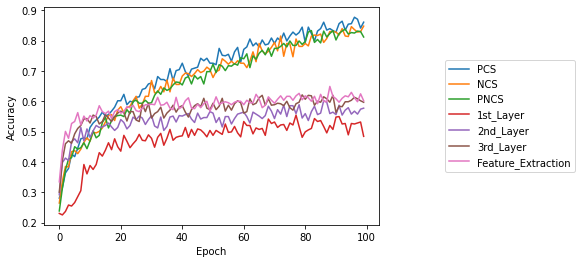

In [23]:
fig1 = plt.figure()
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_loss'])
plt.plot(history2.history['accuracy'])
#plt.plot(history2.history['val_loss'])
plt.plot(history3.history['accuracy'])
#plt.plot(history3.history['val_loss'])
plt.plot(history4.history['accuracy'])
#plt.plot(history4.history['val_loss'])
plt.plot(history5.history['accuracy'])
#plt.plot(history5.history['val_loss'])
plt.plot(history6.history['accuracy'])
#plt.plot(history6.history['val_loss'])
plt.plot(history7.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend(['PCS','NCS','PNCS','1st_Layer','2nd_Layer','3rd_Layer','Feature_Extraction'], loc='lower right')
plt.legend(['PCS','NCS','PNCS','1st_Layer','2nd_Layer','3rd_Layer','Feature_Extraction'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig1.savefig('all_similarity_breast_resnet50.eps', dpi=1200, format="eps", bbox_inches="tight")
plt.show()

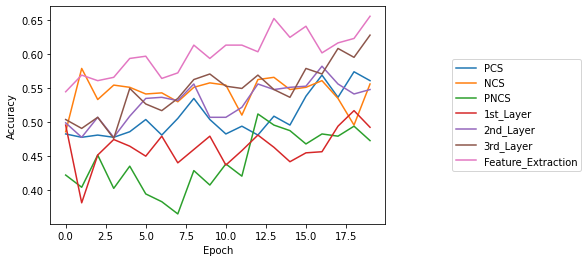

In [54]:
fig1 = plt.figure()
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_loss'])
plt.plot(history2.history['accuracy'])
#plt.plot(history2.history['val_loss'])
plt.plot(history3.history['accuracy'])
#plt.plot(history3.history['val_loss'])
plt.plot(history4.history['accuracy'])
#plt.plot(history4.history['val_loss'])
plt.plot(history5.history['accuracy'])
#plt.plot(history5.history['val_loss'])
plt.plot(history6.history['accuracy'])
#plt.plot(history6.history['val_loss'])
plt.plot(history7.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend(['PCS','NCS','PNCS','1st_Layer','2nd_Layer','3rd_Layer','Feature_Extraction'], loc='lower right')
plt.legend(['PCS','NCS','PNCS','1st_Layer','2nd_Layer','3rd_Layer','Feature_Extraction'], loc="center right", bbox_to_anchor=(1.6, 0.5))
#fig1.savefig('all_similarity_breast_resnet50.eps', dpi=1200, format="eps", bbox_inches="tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


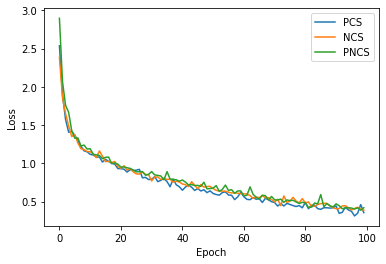

In [27]:
fig3 = plt.figure()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.plot(history.history['loss'])
#plt.plot(history2.history['val_loss'])
plt.plot(history2.history['loss'])
#plt.plot(history3.history['val_loss'])
#plt.plot(history2.history['loss'])
#plt.plot(history4.history['val_loss'])
plt.plot(history3.history['loss'])
#plt.plot(history5.history['val_loss'])
#plt.plot(history3.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend(['PCS_Loss','PCS_Val_Loss','NCS_Loss','NCS_Val_Loss','PNCS_Loss','PNCS_Val_Loss'], loc='upper right')
#plt.legend(['PCS','NCS','PNCS'], loc="center right", bbox_to_anchor=(1.6, 0.5))
plt.legend(['PCS','NCS','PNCS'],  loc='upper right')
fig3.savefig('3plots_Loss_breast_data_resnet50.eps', dpi=1200, format="eps", bbox_inches="tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


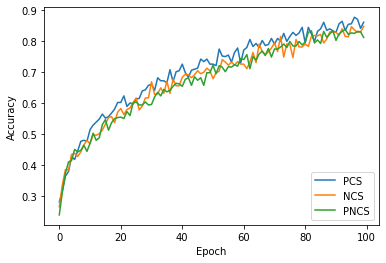

In [29]:
fig2 = plt.figure()
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_loss'])
#plt.plot(history.history['accuracy'])
#plt.plot(history2.history['val_loss'])
plt.plot(history2.history['accuracy'])
#plt.plot(history3.history['val_loss'])
#plt.plot(history2.history['accuracy'])
#plt.plot(history4.history['val_loss'])
plt.plot(history3.history['accuracy'])
#plt.plot(history5.history['val_loss'])
#plt.plot(history3.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend(['PCS_Train','PCS_Val','NCS_Train','NCS_Val','PNCS_Train','PNCS_Val'], loc='upper left')
plt.legend(['PCS','NCS','PNCS'], loc='lower right')
#plt.legend(['PCS_Train','PCS_Val','NCS_Train'], loc="center right", bbox_to_anchor=(1.6, 0.5))
fig2.savefig('3plots_breast_resnet50.eps', dpi=1200, format="eps", bbox_inches="tight")
plt.show()

NameError: name 'plt' is not defined